In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Załadowanie danych

Załadowanie danych z plików csv zarówno z folderów `alpha_diversity`, jak i `input_data` dla `donorA`, `donorB`, `male`, `female` z dniowym krokiem czasowym do pandas DataFrame

In [2]:
import os

alpha_diversity_dir = "data/alpha_diversity/"
input_data_dir = "data/input_data/"

def convert_to_dt_df(file):
    df = pd.read_csv(file)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df['time_step'] = pd.to_timedelta(df['time_step'], unit='D').dt.days
    df.set_index('time_step', inplace=True)
    return df

In [3]:
alpha_diversity_dfs = {}
input_data_dfs = {}

for file in os.listdir(alpha_diversity_dir):
    if file.endswith(".csv"):
        var_name = os.path.splitext(file)[0]
        file_path = os.path.join(alpha_diversity_dir, file)
        alpha_diversity_dfs[var_name] = convert_to_dt_df(file_path)

for file in os.listdir(input_data_dir):
    if file.endswith(".csv"):
        var_name = os.path.splitext(file)[0]
        base_name = var_name.split('_')[0]
        file_path = os.path.join(input_data_dir, file)
        input_data_dfs[base_name] = convert_to_dt_df(file_path)

Połączenie DataFrame w szeregi: `donorA`, `donorB`, `male`, `female`

In [4]:
alpha_diversity_combined_dfs = {}
for name, df in alpha_diversity_dfs.items():
    base_name = name.split('_')[0]

    if base_name not in alpha_diversity_combined_dfs:
        alpha_diversity_combined_dfs[base_name] = df.copy()
    else:
        alpha_diversity_combined_dfs[base_name] = alpha_diversity_combined_dfs[base_name].join(df, how='outer')

## Wizualizacja
Wizualizacja danych szeregów dla obu zbiorów: 
- `alpha_diversity`: parametry `faith_pd` oraz `shannon_entropy` 
- `input_data`: wszystkie szeregi w mikrobiomie oraz sumaryczna liczba mikrobiomu

dla każdego z szeregów: `donorA`, `donorB`, `male`, `female`.

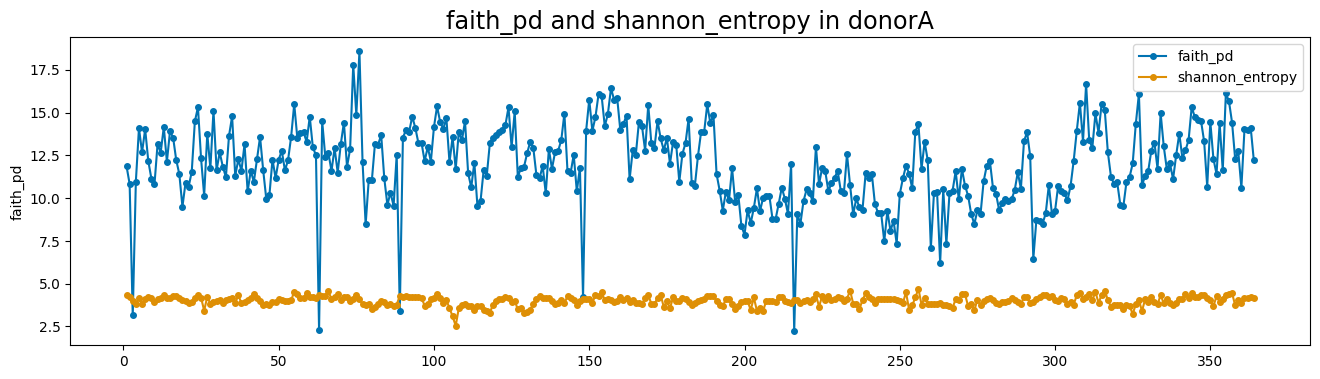

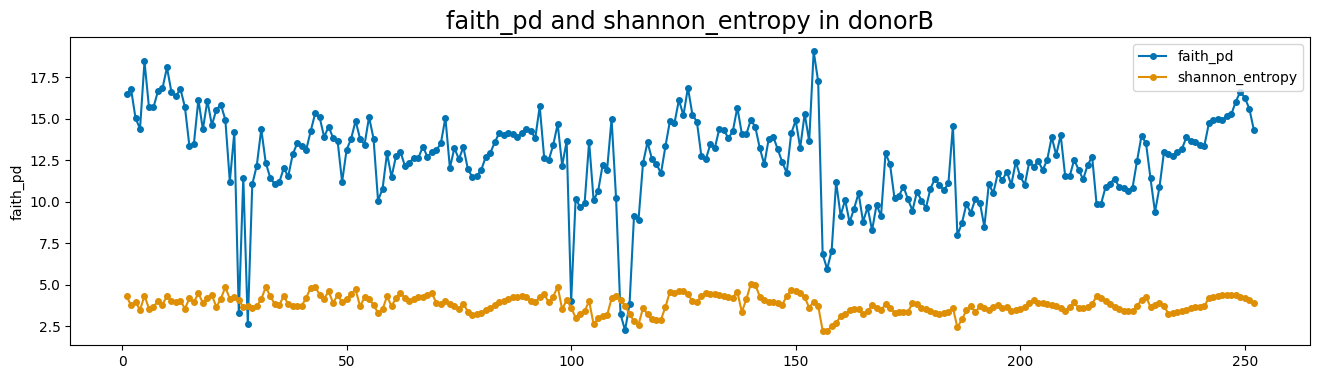

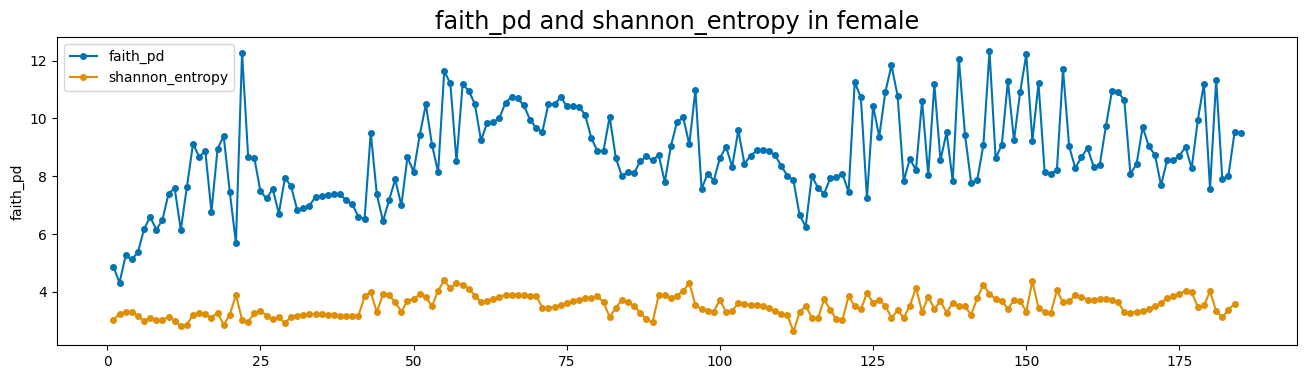

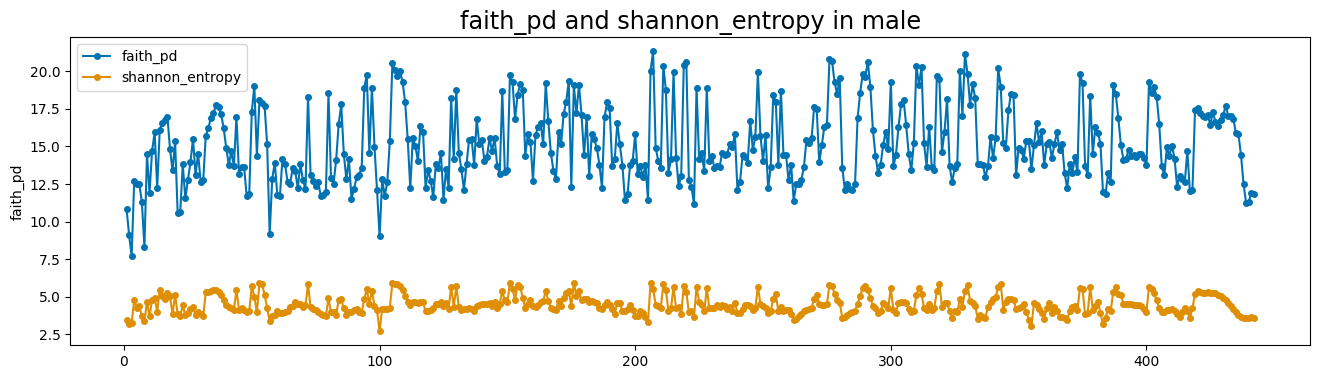

In [5]:
from sktime.utils.plotting import plot_series

# for name, df in alpha_diversity_dfs.items():
#     plot_series(df, title=f"{name}")

for name, df in alpha_diversity_combined_dfs.items():
    plot_series(df["faith_pd"], df["shannon_entropy"], labels=["faith_pd", "shannon_entropy"], title=f"faith_pd and shannon_entropy in {name}")

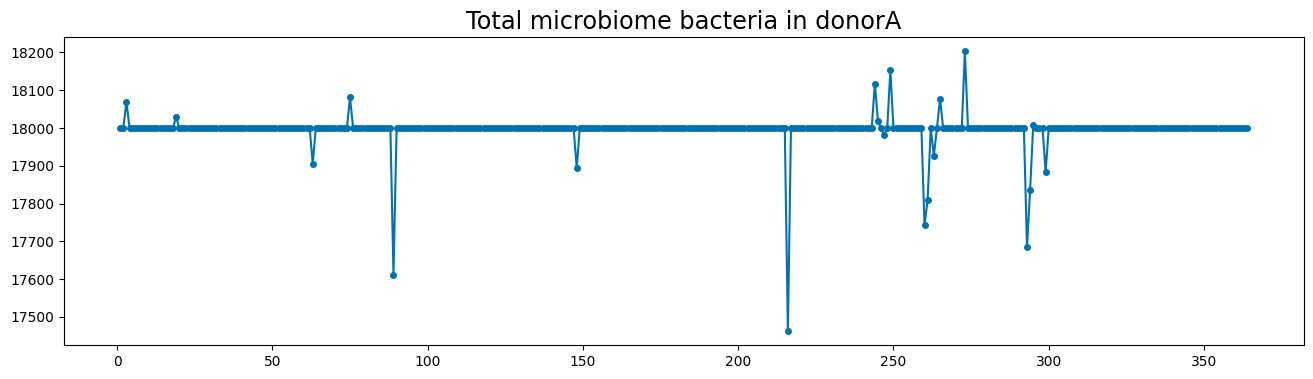

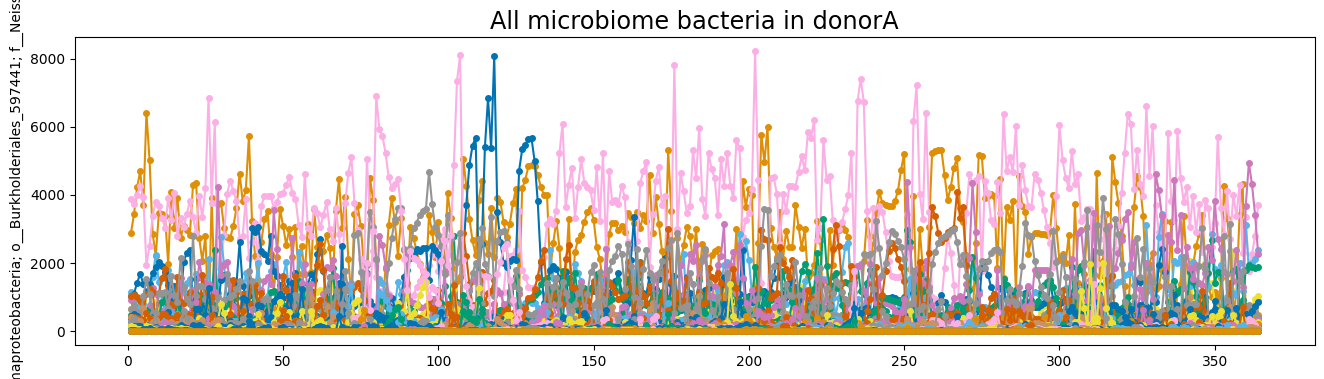

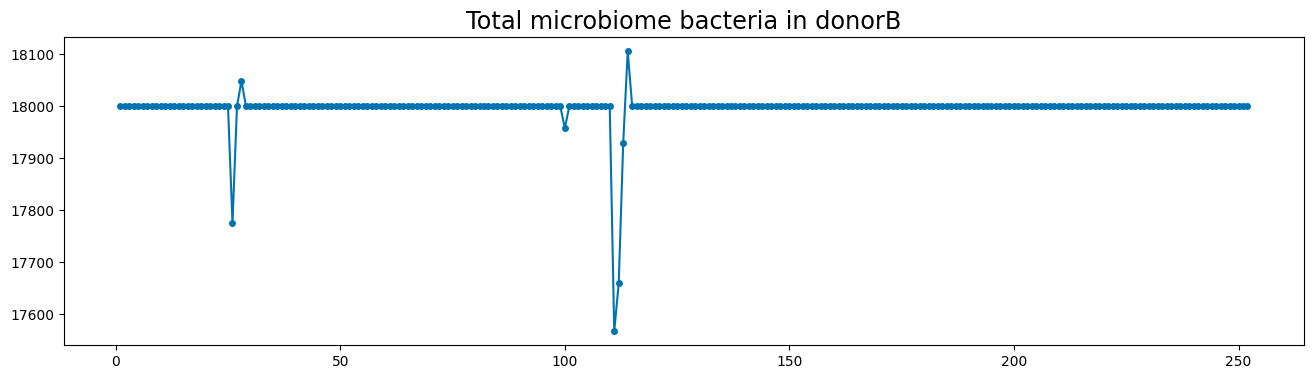

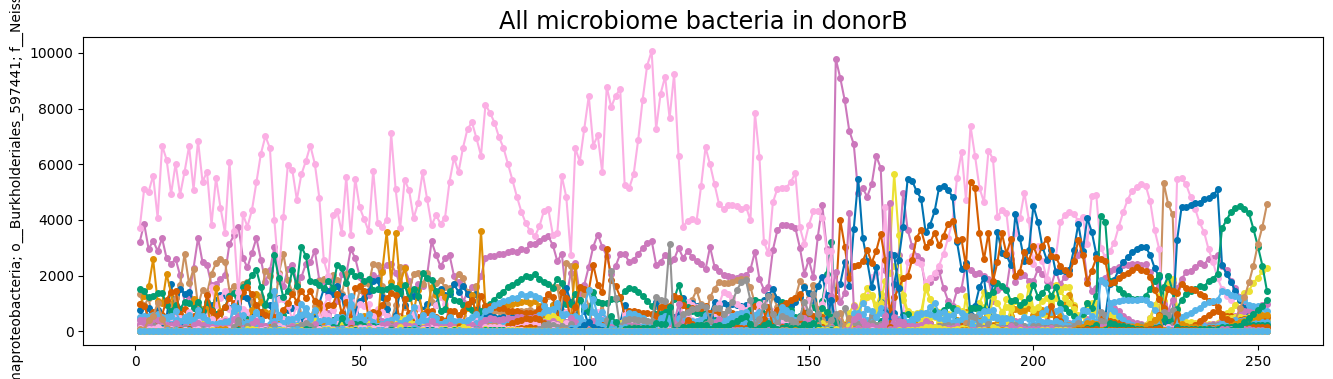

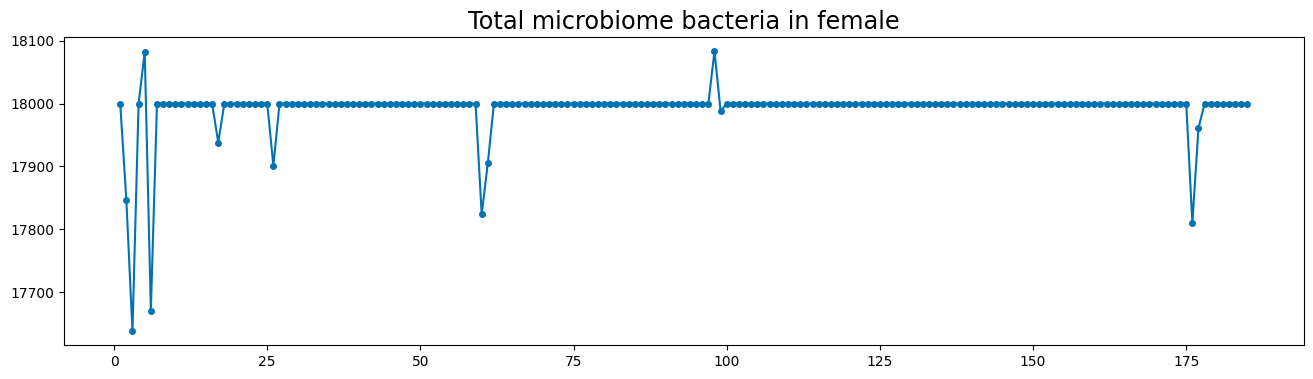

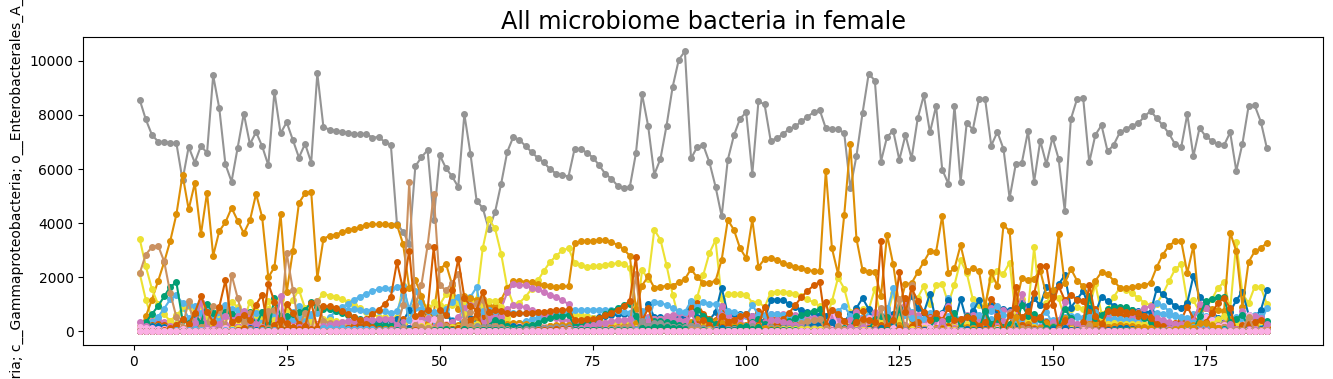

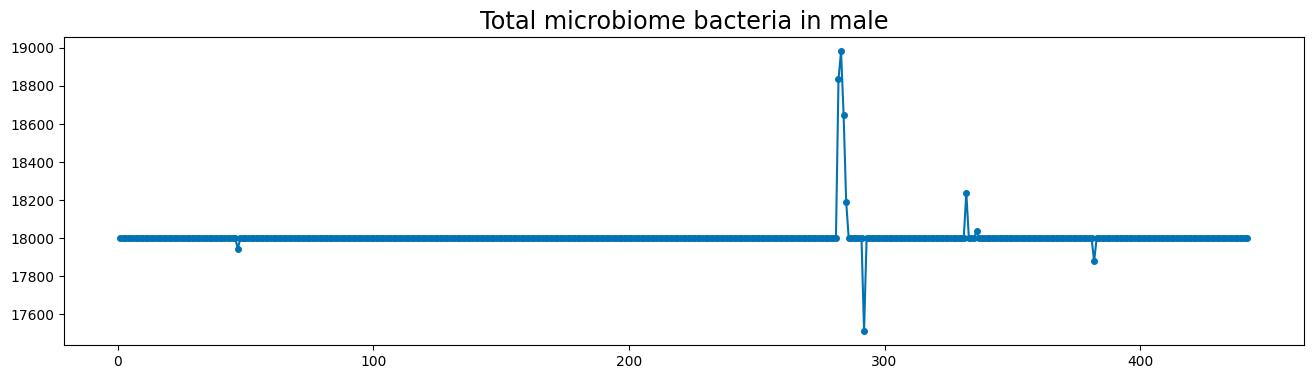

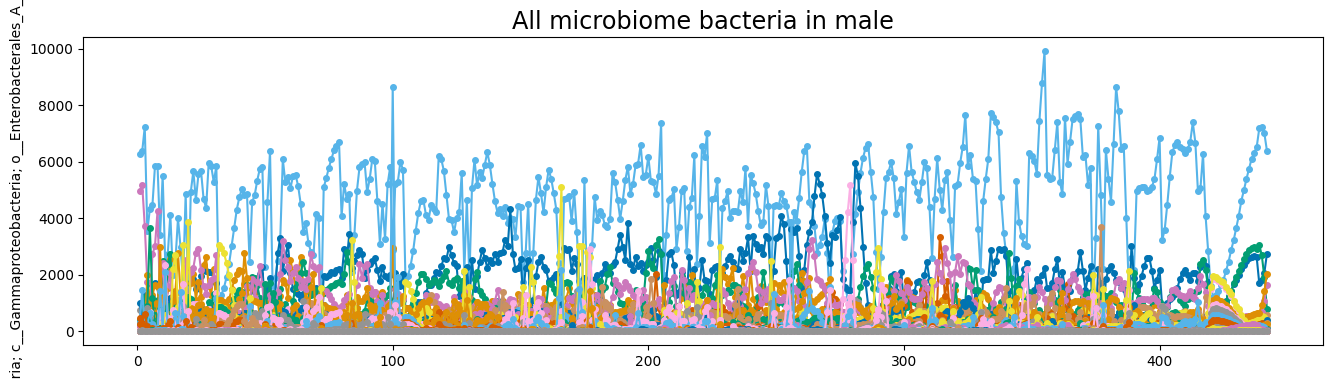

In [6]:
for name, df in input_data_dfs.items():
    plot_series(df.sum(axis="columns"), title=f"Total microbiome bacteria in {name}")

    plot_series(*[df[col] for col in df.columns], labels=None, title=f"All microbiome bacteria in {name}")

## Preprocessing

Podział zbioru danych na treningowy-testowy z forecastem wynoscącym 20% zbioru oraz zbiorem treningowym wynoszącym 80%. Przygotowanie danych (df) w odpowiednim dla frameworku neuralforecast formacie long.

In [7]:
from typing import Optional


def wide_to_long_df(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.melt(df, ignore_index=False).reset_index(names="date")
    df = df.rename(columns={"variable": "unique_id", "date": "ds", "value": "y"})
    return df


def long_to_wide_df(df: pd.DataFrame, values_col: Optional[str] = None) -> pd.DataFrame:
    if "unique_id" not in df.columns:
        df = df.reset_index(names="unique_id")

    values_col = values_col if values_col else df.columns[-1]
    df = pd.pivot(df, columns="unique_id", index="ds", values=values_col)
    return df

In [8]:
def train_test_split(df):
    cutoff = df.index[round(len(df) * 0.8)]
    train = df.loc[df.index < cutoff]
    test = df.loc[df.index >= cutoff]
    return train, test

datasets_long = []

alpha_diversity_train = {}
alpha_diversity_test = {}
alpha_diversity_train_long = {}
alpha_diversity_test_long = {}
for key, df in alpha_diversity_combined_dfs.items():
    alpha_diversity_train[key], alpha_diversity_test[key] = train_test_split(df)
    alpha_diversity_train_long[key] = wide_to_long_df(alpha_diversity_train[key])
    alpha_diversity_test_long[key] = wide_to_long_df(alpha_diversity_test[key])
    datasets_long.append((f"alpha_diversity_{key}", alpha_diversity_train_long[key], alpha_diversity_test_long[key]))

input_data_train = {}
input_data_test = {}
input_data_train_long = {}
input_data_test_long = {}
for key, df in input_data_dfs.items():
    input_data_train[key], input_data_test[key] = train_test_split(df)
    input_data_train_long[key] = wide_to_long_df(input_data_train[key])
    input_data_test_long[key] = wide_to_long_df(input_data_test[key])
    datasets_long.append((f"input_data_{key}", input_data_train_long[key], input_data_test_long[key]))

In [9]:
datasets_long

[('alpha_diversity_donorA',
        ds        unique_id          y
  0      1         faith_pd  11.871713
  1      2         faith_pd  10.830663
  2      3         faith_pd   3.143876
  3      4         faith_pd  10.965869
  4      5         faith_pd  14.088674
  ..   ...              ...        ...
  577  287  shannon_entropy   4.046674
  578  288  shannon_entropy   3.905217
  579  289  shannon_entropy   3.830544
  580  290  shannon_entropy   4.200937
  581  291  shannon_entropy   4.202723
  
  [582 rows x 3 columns],
        ds        unique_id          y
  0    292         faith_pd  12.441495
  1    293         faith_pd   6.455885
  2    294         faith_pd   8.752453
  3    295         faith_pd   8.658799
  4    296         faith_pd   8.510678
  ..   ...              ...        ...
  141  360  shannon_entropy   3.844798
  142  361  shannon_entropy   4.136168
  143  362  shannon_entropy   4.176964
  144  363  shannon_entropy   4.213700
  145  364  shannon_entropy   4.140885
  
  [1

## Trening, ewaluacja

Przygotowanie funkcji treningowej, która przyjmuje model, dane treningowe, testowe i zwraca predykcje. Funkcja treningowa przekazywana jest jako argument funkcji służącej do ewaluacji modelu, gdzie dla każdego szeregu: `donorA`, `donorB`, `male`, `female` mierzone są MAE (Mean Absolute Error) oraz MASE (Mean Absolute Scaled Error) na zbiorze testowym.

In [10]:
# !pip install neuralforecast

In [11]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TCN, TimesNet, TFT
from neuralforecast.auto import AutoTCN, AutoTimesNet, AutoTFT
from neuralforecast.losses.pytorch import MAE
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

c:\Users\URBANCZYKP\Documents\studiaAGH\um\projekt\UM-TimeSeries\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-19 18:16:00,099	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-19 18:16:00,502	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [12]:
import numpy as np
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error
from neuralforecast import NeuralForecast
import time

def forecast_general(df_train_long, df_test_long, model, freq=1):
    nf = NeuralForecast(models=[model], freq=freq)
    
    start_time = time.time()
    nf.fit(df=df_train_long)
    train_time = time.time() - start_time
    
    start_test = time.time()
    forecast_df = nf.predict().reset_index()
    test_time = time.time() - start_test

    y_pred = forecast_df[forecast_df['ds'].isin(df_test_long['ds'])]
    y_pred = y_pred.set_index(['unique_id', 'ds'])
    return y_pred, train_time, test_time

def calculate_mase_for_forecast(y_true, y_pred, y_train):
    return mean_absolute_scaled_error(y_true, y_pred, y_train=y_train)

def evaluate_forecasters(forecasters, datasets, forecast_func):
    results_dict = {}
    for dataset_name, forecaster_name, forecaster_type, forecaster in forecasters:
        for ds_name, df_train_long, df_test_long in datasets:
            if ds_name != dataset_name:
                continue

            y_pred, train_time, test_time = forecast_func(df_train_long, df_test_long, forecaster)
            y_true = df_test_long.set_index(['unique_id', 'ds'])['y']

            common_idx = y_pred.index.intersection(y_true.index)
            y_pred = y_pred.loc[common_idx].dropna()
            y_true = y_true.loc[common_idx].dropna()
            final_idx = y_pred.index.intersection(y_true.index)
            y_pred = y_pred.loc[final_idx]
            y_true = y_true.loc[final_idx]
            if len(y_true) == 0 or len(y_pred) == 0:
                mase = np.nan
            else:
                mase = mean_absolute_scaled_error(
                    y_true=y_true,
                    y_pred=y_pred.iloc[:, 0],
                    y_train=df_train_long['y'].dropna()
                )

            if forecaster_name not in results_dict:
                results_dict[forecaster_name] = {
                    "Forecaster": forecaster_name,
                    "Forecaster type": forecaster_type
                }
            results_dict[forecaster_name][f"MASE ({ds_name})"] = mase
            results_dict[forecaster_name][f"train time ({ds_name})"] = train_time
            results_dict[forecaster_name][f"test time ({ds_name})"] = test_time

    return pd.DataFrame.from_dict(results_dict, orient='index').reset_index(drop=True)


In [13]:
def filter_results(df_results, name):
    return pd.concat([
        df_results.filter(items=["Forecaster", "Forecaster type"], axis=1),
        df_results.filter(regex=f'.*{name}.*', axis=1)
    ], axis=1)

### Trening, ewaluacja modeli TFT, TCN,  TimesNet

Trening modeli: **TFT** (Temporal Fusion Transformer), **TCN** (Temporal Convolutional Network),  **TimesNet** z `forecast_horizon=30` oraz funkcją kosztu **MAE** (Mean Absolute Error). Reszta hiperparametrów modeli dobrana empirycznie.


In [14]:
tft_params = {
    'h': 30,
    'input_size': 14,
    'hidden_size': 64,
    'n_head': 4,
    'dropout': 0.1,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 64,
    'val_check_steps': 50,
    'loss': MAE(),
}

tcn_params = {
    'h': 30,
    'input_size': 30,
    'kernel_size': 3,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}

timesnet_params = {
    'h': 30,
    'input_size': 96,
    'hidden_size': 64,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}


In [15]:
models = []
for ds_name, _, _ in datasets_long:
    tft_model = TFT(**tft_params)
    models.append((ds_name, "TFT", "Transformer", tft_model))
    
    tcn_model = TCN(**tcn_params)
    models.append((ds_name, "TCN", "Convolutional", tcn_model))

    timesnet_model = TimesNet(**timesnet_params)
    models.append((ds_name, "TimesNet", "Convolutional", timesnet_model))

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [16]:
results_df = evaluate_forecasters(models, datasets_long, forecast_general)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder     

Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s, v_num=408, train_loss_step=1.910, train_loss_epoch=1.910]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s, v_num=408, train_loss_step=1.910, train_loss_epoch=1.910]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.03it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode



Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s, v_num=410, train_loss_step=1.090, train_loss_epoch=1.090]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s, v_num=410, train_loss_step=1.090, train_loss_epoch=1.090]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, v_num=412, train_loss_step=0.157, train_loss_epoch=0.157]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, v_num=412, train_loss_step=0.157, train_loss_epoch=0.157]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s, v_num=414, train_loss_step=2.160, train_loss_epoch=2.160]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s, v_num=414, train_loss_step=2.160, train_loss_epoch=2.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.69it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 31.31it/s, v_num=416, train_loss_step=0.831, train_loss_epoch=0.831] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 29.69it/s, v_num=416, train_loss_step=0.831, train_loss_epoch=0.831]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.31it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s, v_num=418, train_loss_step=0.0776, train_loss_epoch=0.0776]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s, v_num=418, train_loss_step=0.0776, train_loss_epoch=0.0776]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.71it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s, v_num=420, train_loss_step=2.220, train_loss_epoch=2.220]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s, v_num=420, train_loss_step=2.220, train_loss_epoch=2.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 34.34it/s, v_num=422, train_loss_step=0.714, train_loss_epoch=0.714] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s, v_num=422, train_loss_step=0.714, train_loss_epoch=0.714]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.73it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s, v_num=424, train_loss_step=0.0499, train_loss_epoch=0.0499]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, v_num=424, train_loss_step=0.0499, train_loss_epoch=0.0499]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s, v_num=426, train_loss_step=1.900, train_loss_epoch=1.900]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s, v_num=426, train_loss_step=1.900, train_loss_epoch=1.900]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.00it/s] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 34.17it/s, v_num=428, train_loss_step=1.480, train_loss_epoch=1.480] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s, v_num=428, train_loss_step=1.480, train_loss_epoch=1.480]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.90it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, v_num=430, train_loss_step=0.132, train_loss_epoch=0.132]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, v_num=430, train_loss_step=0.132, train_loss_epoch=0.132]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.56it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Epoch 11: 100%|██████████| 25/25 [00:02<00:00,  9.74it/s, v_num=432, train_loss_step=0.0151, train_loss_epoch=0.534]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 11: 100%|██████████| 25/25 [00:02<00:00,  9.71it/s, v_num=432, train_loss_step=0.0151, train_loss_epoch=0.534]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 86.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 16.18it/s, v_num=434, train_loss_step=0.167, train_loss_epoch=0.177]  

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 16.01it/s, v_num=434, train_loss_step=0.167, train_loss_epoch=0.177]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:01<00:00, 34.99it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:03<00:22,  1.94it/s, v_num=436, train_loss_step=0.404, train_loss_epoch=0.211]  

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:03<00:22,  1.94it/s, v_num=436, train_loss_step=0.404, train_loss_epoch=0.211]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:04<00:00, 11.05it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Epoch 11: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s, v_num=438, train_loss_step=0.769, train_loss_epoch=0.990] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 11: 100%|██████████| 25/25 [00:02<00:00,  9.39it/s, v_num=438, train_loss_step=0.769, train_loss_epoch=0.990]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 66.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 14.41it/s, v_num=440, train_loss_step=0.397, train_loss_epoch=0.305]   

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:00<00:03, 14.30it/s, v_num=440, train_loss_step=0.397, train_loss_epoch=0.305]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 56.47it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:03<00:23,  1.80it/s, v_num=442, train_loss_step=0.386, train_loss_epoch=0.335]  

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:03<00:23,  1.80it/s, v_num=442, train_loss_step=0.386, train_loss_epoch=0.335]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:04<00:00, 10.93it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Epoch 33:  33%|███▎      | 3/9 [00:00<00:00,  7.60it/s, v_num=444, train_loss_step=1.880, train_loss_epoch=1.360]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 33:  33%|███▎      | 3/9 [00:00<00:00,  7.49it/s, v_num=444, train_loss_step=1.880, train_loss_epoch=1.360]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 54.87it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 16:  67%|██████▋   | 12/18 [00:00<00:00, 36.22it/s, v_num=446, train_loss_step=1.510, train_loss_epoch=0.808]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 16:  67%|██████▋   | 12/18 [00:00<00:00, 35.78it/s, v_num=446, train_loss_step=1.510, train_loss_epoch=0.808]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 67.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 16:  67%|██████▋   | 12/18 [00:05<00:02,  2.02it/s, v_num=448, train_loss_step=0.424, train_loss_epoch=0.389]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 16:  67%|██████▋   | 12/18 [00:05<00:02,  2.02it/s, v_num=448, train_loss_step=0.424, train_loss_epoch=0.389]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 18/18 [00:01<00:00, 11.30it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Epoch 14: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s, v_num=450, train_loss_step=1.060, train_loss_epoch=1.050]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 14: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s, v_num=450, train_loss_step=1.060, train_loss_epoch=1.050]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 65.48it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 7:  50%|█████     | 20/40 [00:00<00:00, 34.47it/s, v_num=452, train_loss_step=3.410, train_loss_epoch=0.726]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 7:  50%|█████     | 20/40 [00:00<00:00, 34.29it/s, v_num=452, train_loss_step=3.410, train_loss_epoch=0.726]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 35.10it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Epoch 7:  50%|█████     | 20/40 [00:10<00:10,  1.96it/s, v_num=454, train_loss_step=0.382, train_loss_epoch=0.472] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 7:  50%|█████     | 20/40 [00:10<00:10,  1.96it/s, v_num=454, train_loss_step=0.382, train_loss_epoch=0.472]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s]


In [17]:
filter_results(results_df, "MASE")

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male)
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.131919,2.070918,1.201786,1.137052
2,TimesNet,Convolutional,1.495748,0.881907,1.237052,1.021211,1.114875,1.523926,1.109639,1.213366


In [18]:
filter_results(results_df, "time")

,Forecaster,Forecaster type,train time (alpha_diversity_donorA),test time (alpha_diversity_donorA),train time (alpha_diversity_donorB),test time (alpha_diversity_donorB),train time (alpha_diversity_female),test time (alpha_diversity_female),train time (alpha_diversity_male),test time (alpha_diversity_male),train time (input_data_donorA),test time (input_data_donorA),train time (input_data_donorB),test time (input_data_donorB),train time (input_data_female),test time (input_data_female),train time (input_data_male),test time (input_data_male)
0,TFT,Transformer,23.017486,0.130635,29.755203,0.101070,29.810233,0.092123,30.086711,0.091851,30.848857,0.409229,31.026690,0.536016,30.619895,0.294365,30.876479,0.461989
1,TCN,Convolutional,10.822634,0.131820,6.202725,0.110911,6.028330,0.096677,6.056333,0.133398,7.043900,1.638672,7.576981,1.028323,6.261606,0.381952,7.241502,1.287482
2,TimesNet,Convolutional,144.342198,0.124441,137.323943,0.340908,132.501291,0.181545,142.947696,0.141852,142.369622,4.566663,152.404259,4.618135,148.967507,1.709350,154.881982,3.742789


### Trening, ewaluacja modeli rekurencyjnych RNN, LSTM

Trening modeli: **RNN** (Recurrent Neural Network), **LSTM** (Long Short-Term Memory) z `forecast_horizon=30` oraz funkcją kosztu **MAE** (Mean Absolute Error). Reszta hiperparametrów modeli dobrana empirycznie.

In [19]:
from neuralforecast.models import RNN, LSTM

rnn_params = {
    'h': 30,
    'input_size': 60,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}

lstm_params = {
    'h': 30,
    'input_size': 60,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}

In [20]:
recurrent_models = []
for ds_name, _, _ in datasets_long:
    rnn_model = RNN(**rnn_params)
    recurrent_models.append((ds_name, "RNN", "Recurrent", rnn_model))

    lstm_model = LSTM(**lstm_params)
    recurrent_models.append((ds_name, "LSTM", "Recurrent", lstm_model))

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [21]:
results_recurrent_df = evaluate_forecasters(recurrent_models, datasets_long, forecast_general)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s, v_num=456, train_loss_step=1.010, train_loss_epoch=1.010] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s, v_num=456, train_loss_step=1.010, train_loss_epoch=1.010]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.97it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, v_num=458, train_loss_step=1.180, train_loss_epoch=1.180] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s, v_num=458, train_loss_step=1.180, train_loss_epoch=1.180]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.01it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 41.14it/s, v_num=460, train_loss_step=1.110, train_loss_epoch=1.110] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 30.26it/s, v_num=460, train_loss_step=1.110, train_loss_epoch=1.110]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.60it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 24.35it/s, v_num=462, train_loss_step=1.180, train_loss_epoch=1.180] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 24.35it/s, v_num=462, train_loss_step=1.180, train_loss_epoch=1.180]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.78it/s]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 37.86it/s, v_num=464, train_loss_step=0.693, train_loss_epoch=0.693] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s, v_num=464, train_loss_step=0.693, train_loss_epoch=0.693]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.55it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s, v_num=466, train_loss_step=0.748, train_loss_epoch=0.748] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s, v_num=466, train_loss_step=0.748, train_loss_epoch=0.748]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.31it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s, v_num=468, train_loss_step=1.070, train_loss_epoch=1.070] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s, v_num=468, train_loss_step=1.070, train_loss_epoch=1.070]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s, v_num=470, train_loss_step=1.290, train_loss_epoch=1.290] 

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s, v_num=470, train_loss_step=1.290, train_loss_epoch=1.290]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.99it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 17.73it/s, v_num=472, train_loss_step=0.193, train_loss_epoch=0.253]  

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 17.59it/s, v_num=472, train_loss_step=0.193, train_loss_epoch=0.253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 54.09it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 16.42it/s, v_num=474, train_loss_step=0.194, train_loss_epoch=0.252]  

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 15.62it/s, v_num=474, train_loss_step=0.194, train_loss_epoch=0.252]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:01<00:00, 29.54it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 17.05it/s, v_num=476, train_loss_step=0.571, train_loss_epoch=0.348]   

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 16.90it/s, v_num=476, train_loss_step=0.571, train_loss_epoch=0.348]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 62.10it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 14.98it/s, v_num=478, train_loss_step=0.579, train_loss_epoch=0.347]    

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 6:  12%|█▏        | 6/49 [00:00<00:02, 14.98it/s, v_num=478, train_loss_step=0.579, train_loss_epoch=0.347]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 49/49 [00:01<00:00, 39.70it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 16:  67%|██████▋   | 12/18 [00:00<00:00, 49.38it/s, v_num=480, train_loss_step=0.904, train_loss_epoch=0.640]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 16:  67%|██████▋   | 12/18 [00:00<00:00, 49.38it/s, v_num=480, train_loss_step=0.904, train_loss_epoch=0.640]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 88.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 16:  67%|██████▋   | 12/18 [00:00<00:00, 30.80it/s, v_num=482, train_loss_step=0.904, train_loss_epoch=0.635]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 16:  67%|██████▋   | 12/18 [00:00<00:00, 30.38it/s, v_num=482, train_loss_step=0.904, train_loss_epoch=0.635]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 51.83it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 7:  50%|█████     | 20/40 [00:00<00:00, 37.99it/s, v_num=484, train_loss_step=0.931, train_loss_epoch=0.567]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 7:  50%|█████     | 20/40 [00:00<00:00, 37.85it/s, v_num=484, train_loss_step=0.931, train_loss_epoch=0.567]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 47.18it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 7:  50%|█████     | 20/40 [00:00<00:00, 28.89it/s, v_num=486, train_loss_step=0.928, train_loss_epoch=0.566]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 7:  50%|█████     | 20/40 [00:00<00:00, 28.51it/s, v_num=486, train_loss_step=0.928, train_loss_epoch=0.566]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 25.29it/s]


In [22]:
filter_results(results_recurrent_df, "MASE")

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male)
0,RNN,Recurrent,1.452844,0.700764,1.063486,1.024115,1.136139,1.761242,1.173703,1.111239
1,LSTM,Recurrent,1.253489,0.763220,1.023611,0.809704,1.127478,1.904902,1.170512,1.127681


In [23]:
filter_results(results_recurrent_df, "time")

,Forecaster,Forecaster type,train time (alpha_diversity_donorA),test time (alpha_diversity_donorA),train time (alpha_diversity_donorB),test time (alpha_diversity_donorB),train time (alpha_diversity_female),test time (alpha_diversity_female),train time (alpha_diversity_male),test time (alpha_diversity_male),train time (input_data_donorA),test time (input_data_donorA),train time (input_data_donorB),test time (input_data_donorB),train time (input_data_female),test time (input_data_female),train time (input_data_male),test time (input_data_male)
0,RNN,Recurrent,5.295772,0.078673,5.753363,0.075749,5.580466,0.110950,5.565017,0.074829,6.507806,1.033943,6.332191,0.916661,5.376474,0.314374,6.222630,0.959098
1,LSTM,Recurrent,7.827292,0.093309,7.678781,0.077229,7.674504,0.087401,7.656458,0.103267,8.817308,1.797031,8.895642,1.355271,7.877193,0.430223,8.644219,1.686442


### Trening, ewaluacja modeli ARIMA, ETS

Trening modeli: **ARIMA** (Auto Regressive Integrated Moving Average), **ETS** (ExponentialSmoothingModel).

In [24]:
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, ETS

def forecast_statsforecast(df_train_long, df_test_long, stats_model, freq=1):
    h = df_test_long['ds'].nunique()
    sf = StatsForecast(models=[stats_model], freq=freq)
    
    start_time = time.time()
    sf.fit(df=df_train_long)
    train_time = time.time() - start_time
    
    start_time = time.time()
    forecast_df = sf.predict(h=h).reset_index()
    test_time = time.time() - start_time
    
    model_col = stats_model.__class__.__name__
    forecast_df = forecast_df.rename(columns={model_col: 'y_pred'})

    merged_df = pd.merge(
        forecast_df[['unique_id', 'ds', 'y_pred']],
        df_test_long[['unique_id', 'ds']],
        on=['unique_id', 'ds'],
        how='inner'
    )

    return merged_df.set_index(['unique_id', 'ds'])[['y_pred']], train_time, test_time

In [25]:
statistical_models = []
for ds_name, _, _ in datasets_long:
    arima_model = ARIMA()
    statistical_models.append((ds_name, "ARIMA", "Statistical", arima_model))
    
    ets_model = ETS()
    statistical_models.append((ds_name, "ETS", "Statistical", ets_model))

In [26]:
results_statistical_df = evaluate_forecasters(statistical_models, datasets_long, forecast_statsforecast)

In [27]:
filter_results(results_statistical_df, "MASE")

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male)
0,ARIMA,Statistical,1.120042,0.936906,1.029656,0.925325,1.420105,2.510926,1.352210,1.494939
1,ETS,Statistical,1.092582,1.026449,1.137352,0.961094,1.830633,2.072330,1.289538,1.581058


In [28]:
filter_results(results_statistical_df, "time")

,Forecaster,Forecaster type,train time (alpha_diversity_donorA),test time (alpha_diversity_donorA),train time (alpha_diversity_donorB),test time (alpha_diversity_donorB),train time (alpha_diversity_female),test time (alpha_diversity_female),train time (alpha_diversity_male),test time (alpha_diversity_male),train time (input_data_donorA),test time (input_data_donorA),train time (input_data_donorB),test time (input_data_donorB),train time (input_data_female),test time (input_data_female),train time (input_data_male),test time (input_data_male)
0,ARIMA,Statistical,0.022978,0.0,0.010556,0.0,0.020231,0.0,0.00000,0.005973,16.337614,1.048263,14.791680,0.685369,4.741639,0.199181,15.102977,1.011501
1,ETS,Statistical,0.041230,0.0,0.023764,0.0,0.009362,0.0,0.05973,0.000000,22.335477,0.035506,15.826253,0.029438,3.790975,0.009264,29.336609,0.058545


## Wyniki

In [29]:
final_results_df = pd.concat([results_df, results_recurrent_df, results_statistical_df], axis=0)
final_results_df.reset_index(drop=True, inplace=True)
final_results_df

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),train time (alpha_diversity_donorA),test time (alpha_diversity_donorA),MASE (alpha_diversity_donorB),train time (alpha_diversity_donorB),test time (alpha_diversity_donorB),MASE (alpha_diversity_female),train time (alpha_diversity_female),...,test time (input_data_donorA),MASE (input_data_donorB),train time (input_data_donorB),test time (input_data_donorB),MASE (input_data_female),train time (input_data_female),test time (input_data_female),MASE (input_data_male),train time (input_data_male),test time (input_data_male)
0,TFT,Transformer,1.427697,23.017486,0.130635,0.648422,29.755203,0.101070,3.539659,29.810233,...,0.409229,1.368846,31.026690,0.536016,1.032208,30.619895,0.294365,1.150807,30.876479,0.461989
1,TCN,Convolutional,1.295229,10.822634,0.131820,0.936870,6.202725,0.110911,0.944631,6.028330,...,1.638672,2.070918,7.576981,1.028323,1.201786,6.261606,0.381952,1.137052,7.241502,1.287482
2,TimesNet,Convolutional,1.495748,144.342198,0.124441,0.881907,137.323943,0.340908,1.237052,132.501291,...,4.566663,1.523926,152.404259,4.618135,1.109639,148.967507,1.709350,1.213366,154.881982,3.742789
3,RNN,Recurrent,1.452844,5.295772,0.078673,0.700764,5.753363,0.075749,1.063486,5.580466,...,1.033943,1.761242,6.332191,0.916661,1.173703,5.376474,0.314374,1.111239,6.222630,0.959098
4,LSTM,Recurrent,1.253489,7.827292,0.093309,0.763220,7.678781,0.077229,1.023611,7.674504,...,1.797031,1.904902,8.895642,1.355271,1.170512,7.877193,0.430223,1.127681,8.644219,1.686442
5,ARIMA,Statistical,1.120042,0.022978,0.000000,0.936906,0.010556,0.000000,1.029656,0.020231,...,1.048263,2.510926,14.791680,0.685369,1.352210,4.741639,0.199181,1.494939,15.102977,1.011501
6,ETS,Statistical,1.092582,0.041230,0.000000,1.026449,0.023764,0.000000,1.137352,0.009362,...,0.035506,2.072330,15.826253,0.029438,1.289538,3.790975,0.009264,1.581058,29.336609,0.058545


## Wyniki - time

Wypisanie zagregowanych wyników czasu przetwarzania, wykresy dla poszczególnych modeli dla każdego modelu z rozdziałem na ttain/test. 


In [30]:
import seaborn as sns

def sum_and_mean_results_cols(df_results, names):
    for name in names:
        sum_col = f"{name}_sum"
        mean_col = f"{name}_mean"
        df_results[sum_col] = df_results.filter(regex=f'.*{name}.*', axis=1).sum(axis=1)
        df_results[mean_col] = df_results.filter(regex=f'.*{name}.*', axis=1).mean(axis=1)
    return df_results
     

def plot_forecasters_comparison(df_results, names, metric="mean"):
    metric_suffix = f"_{metric}"
    
    for name in names:
        col = f"{name}{metric_suffix}"
        plt.figure(figsize=(8, 5))
        sns.barplot(data=df_results, x="Forecaster", y=col, ci=None, palette="viridis")
        plt.title(f"{name.capitalize()} {metric.capitalize()} Comparison Across Forecasters")
        plt.ylabel(f"{name.capitalize()} {metric.capitalize()}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


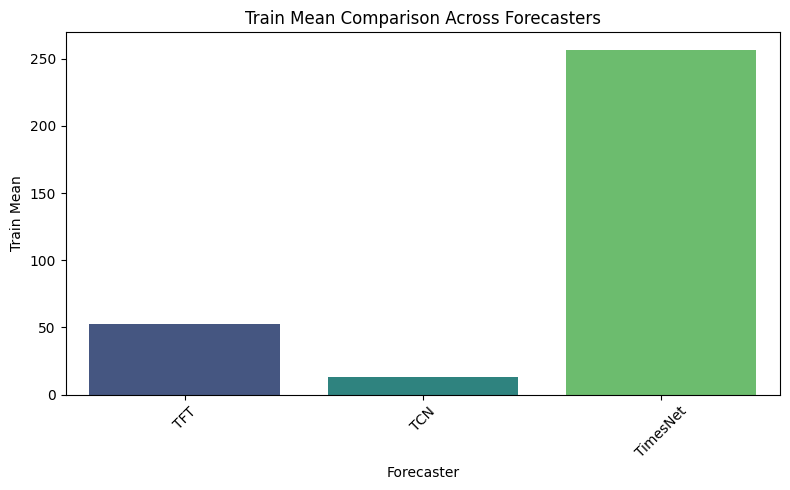

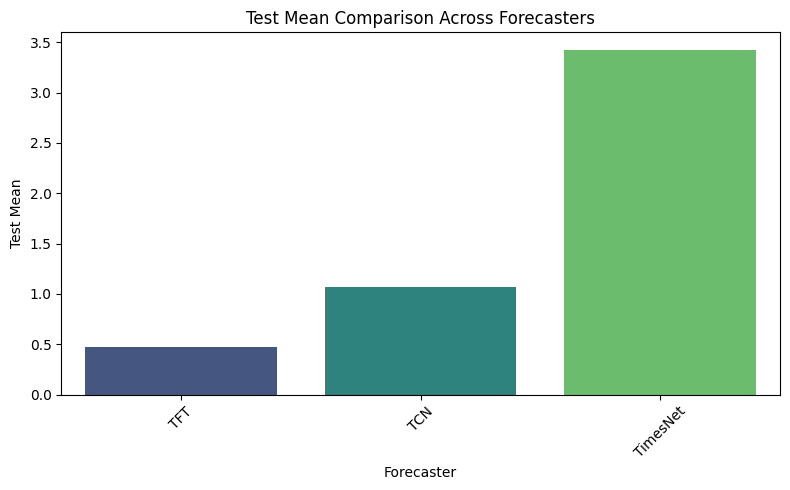

In [31]:
results_time = filter_results(results_df, "time")
results_time = sum_and_mean_results_cols(results_time, ["train", "test"])
plot_forecasters_comparison(results_time, ["train", "test"], metric="mean")

## Wyniki - MASE

Wypisanie zagregowanych wyników, wykresy dla poszczególnych modeli dla obu zbiorów (`alpha_diversity`, `input_data`) osobno oraz razem (MASE). 

In [32]:
def plot_results(df, donor_groups, weights):
    forecasters = df['Forecaster']

    plt.figure(figsize=(12, 8))
    x = np.arange(len(forecasters))

    bar_width = 0.1
    offsets = np.linspace(-bar_width * len(donor_groups) / 2, bar_width * len(donor_groups) / 2, len(donor_groups))

    colors = plt.cm.tab10(np.linspace(0, 1, len(donor_groups)))

    for i, group in enumerate(donor_groups):
        plt.bar(x + offsets[i], df[group], bar_width, label=group, color=colors[i], alpha=0.7)
        plt.plot(x + offsets[i], df[group], marker='o', color=colors[i], linestyle='-', alpha=0.9)

    normalized_weights = np.array(weights) / sum(weights)
    weighted_mean_mase = (df[donor_groups] * normalized_weights).sum(axis=1)

    plt.plot(x, weighted_mean_mase, marker='D', color='blue', linestyle='--', label='Weighted Mean MASE', markersize=8, alpha=0.8)

    for i, mean in enumerate(weighted_mean_mase):
        plt.text(x[i], mean + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

    plt.xticks(x, forecasters, rotation=45, ha='right')
    plt.xlabel("Forecasters")
    plt.ylabel("MASE Values")
    plt.title("MASE Comparison Across Donor Groups and Models")
    plt.legend(title="Donor Groups", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

def get_weighted_mean_per_forecaster(df, donor_groups, weights):
    """Calculate weighted mean MASE for specified donor groups."""
    normalized_weights = np.array(weights) / sum(weights)
    weighted_mean = (df[donor_groups] * normalized_weights).sum(axis=1)
    df['Weighted_Mean_MASE'] = weighted_mean
    return df

def get_weights(df, donor_groups):
    weights = 1 / df[donor_groups].mean(axis=0)
    weights = weights / weights.sum()
    return weights


In [33]:
final_results_mase_df = filter_results(results_df, "MASE")

### alpha_diversity

In [34]:
donor_groups_alpha_diversity = [
    "MASE (alpha_diversity_donorA)", "MASE (alpha_diversity_donorB)",
    "MASE (alpha_diversity_female)", "MASE (alpha_diversity_male)",
]

weights_alpha_diversity = get_weights(final_results_mase_df, donor_groups_alpha_diversity)

mean_values_alpha_diversity = get_weighted_mean_per_forecaster(final_results_mase_df, donor_groups_alpha_diversity, weights_alpha_diversity)
mean_values_alpha_diversity.sort_values(by="Weighted_Mean_MASE", ascending=True)

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male),Weighted_Mean_MASE
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.131919,2.070918,1.201786,1.137052,0.969429
2,TimesNet,Convolutional,1.495748,0.881907,1.237052,1.021211,1.114875,1.523926,1.109639,1.213366,1.103231
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807,1.426945


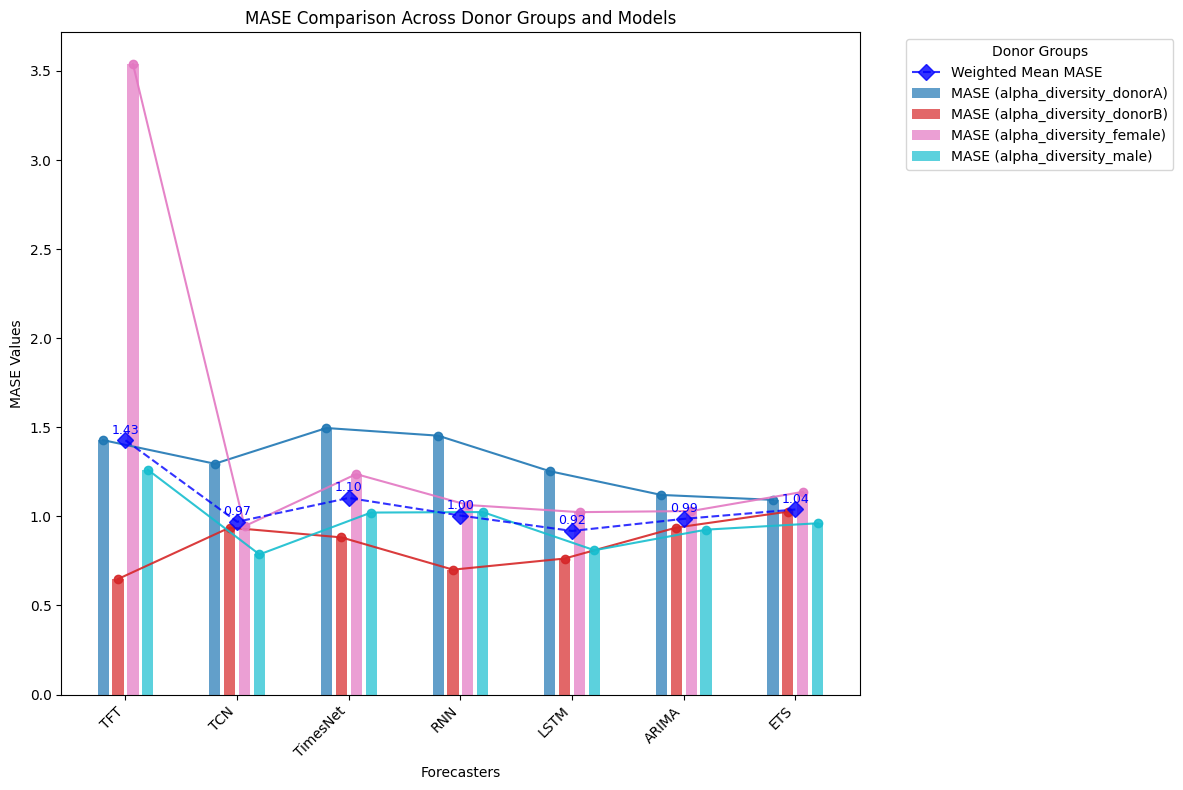

In [35]:
plot_results(final_results_df, donor_groups_alpha_diversity, weights_alpha_diversity)

### input_data

In [36]:
donor_groups_input_data = [
    "MASE (input_data_donorA)", "MASE (input_data_donorB)",
    "MASE (input_data_female)", "MASE (input_data_male)"
]

weights_input_data = get_weights(final_results_mase_df, donor_groups_input_data)

mean_values_input_data = get_weighted_mean_per_forecaster(final_results_mase_df, donor_groups_input_data, weights_input_data)
mean_values_input_data.sort_values(by="Weighted_Mean_MASE", ascending=True)

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male),Weighted_Mean_MASE
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807,1.153722
2,TimesNet,Convolutional,1.495748,0.881907,1.237052,1.021211,1.114875,1.523926,1.109639,1.213366,1.215586
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.131919,2.070918,1.201786,1.137052,1.327416


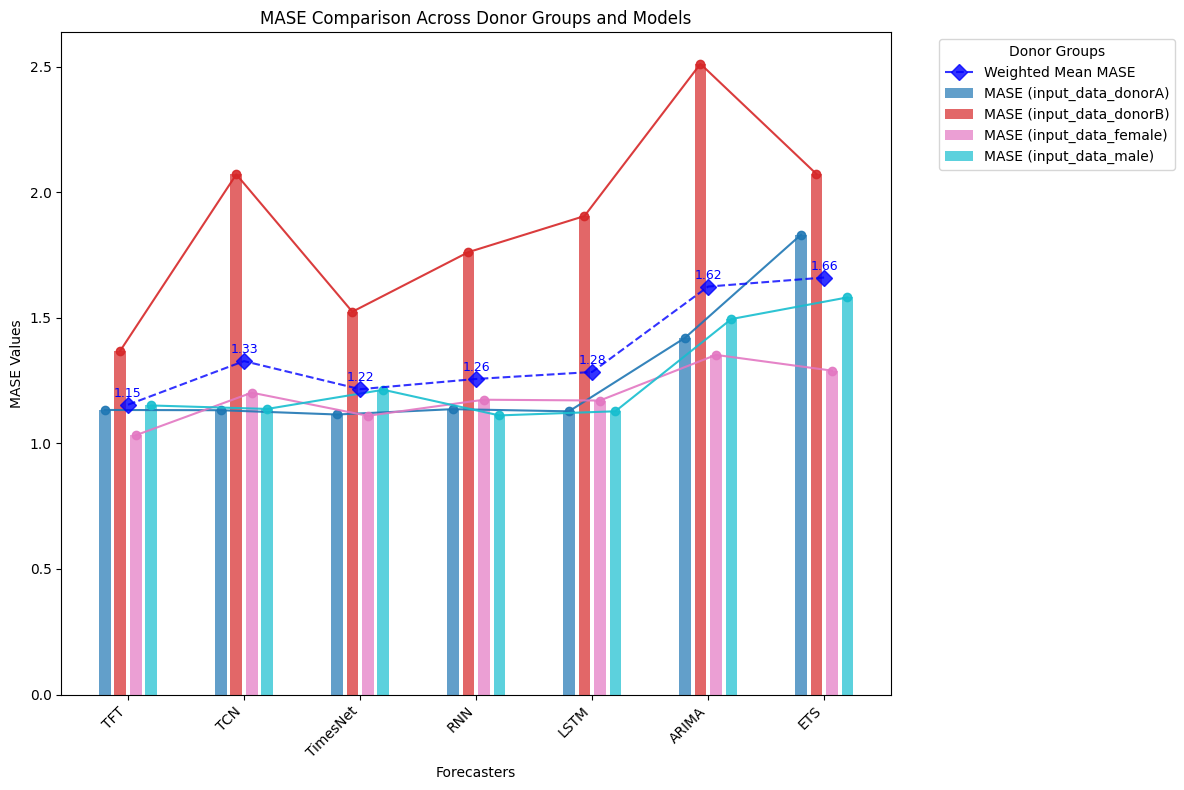

In [37]:
plot_results(final_results_df, donor_groups_input_data, weights_input_data)

## All datasets

In [38]:
donor_groups_all = [
    "MASE (alpha_diversity_donorA)", "MASE (alpha_diversity_donorB)",
    "MASE (alpha_diversity_female)", "MASE (alpha_diversity_male)",
    "MASE (input_data_donorA)", "MASE (input_data_donorB)",
    "MASE (input_data_female)", "MASE (input_data_male)"
]

weights_all = get_weights(final_results_mase_df, donor_groups_all)

mean_values_all = get_weighted_mean_per_forecaster(final_results_mase_df, donor_groups_all, weights_all)
mean_values_all.sort_values(by="Weighted_Mean_MASE", ascending=True)

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male),Weighted_Mean_MASE
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.131919,2.070918,1.201786,1.137052,1.143520
2,TimesNet,Convolutional,1.495748,0.881907,1.237052,1.021211,1.114875,1.523926,1.109639,1.213366,1.157870
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807,1.294076


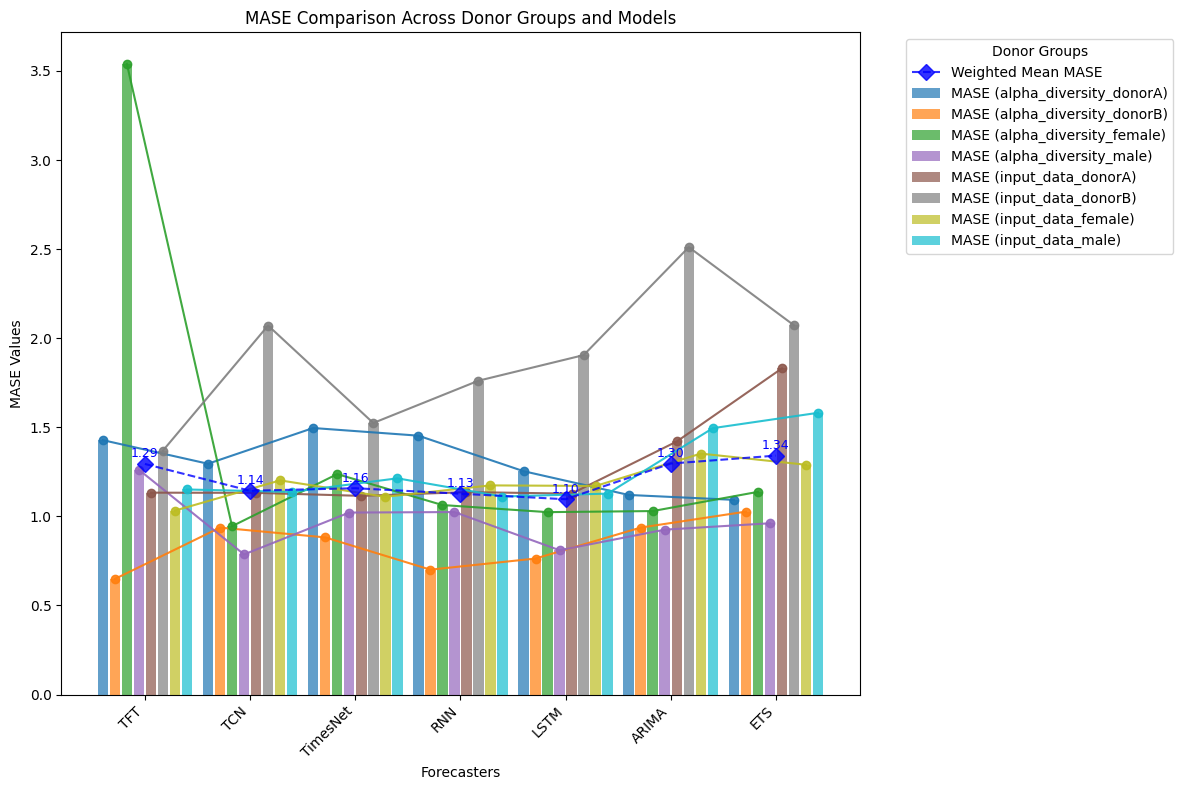

In [39]:
plot_results(final_results_df, donor_groups_all, weights_all)

## Wnioski

- **donorB** wypada najlepiej dla `alpha_diversity` w porównaniu z innymi donorami, natomiast na `input_data` najgorzej dla praktycznie każdego modelu
- **TFT** dla `alpha_diversity` **female** poradził sobie najgorzej, natomiast w przypadku `input_data` najlepiej w porównaniu z innymi modelami
- ze względu na wyraźne różnice w średnich wartościach błędów dla poszczególnych donorów zastosowaliśmy średnią ważoną z wagami uzależnionymi od poszczególnych donorów 
- najlepszym modelem w przypadku `alpha_diversity` jest **LSTM**, natomiast najgorszym **TFT**
- najlepszym modelem w przypadku `input_data` jest **TFT**, natomiast najgorszym **ETS**
- najlepszym modelem licząc oba zbiory razem jest **LSTM**, natomiast najgorszym **TFT**
- słaby wynik **TFT** jest bezpośrednio podyktowany wysokim błędem **female** na zbiorze `alpha_diversity`
